In [2]:
import logging
import os
import re
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import properscoring as ps
import requests
import xarray as xr
import xesmf as xe
from dask.distributed import Client, LocalCluster
from hwt import firstRun, mask0p5, mask0p25
from metpy.constants import g
from tqdm.notebook import tqdm

# Place where Dave cached datasets for quicker use
CACHEDIR = Path("/glade/derecho/scratch/ahijevyc/ldmason_hwt")

init_times23 = pd.date_range(firstRun(2023), pd.to_datetime(f"{2023}0531"), freq="24h")
init_times24 = pd.date_range(firstRun(2024), pd.to_datetime(f"{2024}0531"), freq="24h")

# Combine 2023 and 2024
init_times = init_times23.union(init_times24)
# sorted list of unique years in init_times
years = sorted(list(set(i.year for i in init_times)))

forecast_length = 240

In [3]:
shortName, isobaricInhPa, units = "z", 500, "m"
era5_varid = {"z": 129, "t": 130}
mpas_rename = {"height_500hPa": "z", "temperature_850hPa": "t"}

In [47]:
ds_mpas = (
    xr.open_zarr(CACHEDIR / f"mpas15-3km.zarr", consolidated=False).rename(
        lat="latitude",
        lon="longitude",
        member="number",
        t850="t",
        z500="z",
    )
    .squeeze(dim="time")
    .assign_coords(
        valid_time=lambda x: x["initialization_time"] + x["forecast_hour"] * pd.Timedelta("1h")
    )
)
ds_mpas["z"] = ds_mpas["z"] / g.m
ds_fv3 = xr.open_zarr(CACHEDIR / f"fv3.zarr")
ds_gefs = xr.open_zarr(CACHEDIR / f"gefs.{isobaricInhPa}{shortName}.{years}.{forecast_length:03d}h.zarr", decode_timedelta=False)
ds_pangu = xr.open_zarr(CACHEDIR / f"pangu.{isobaricInhPa}{shortName}.{years}.{forecast_length:03d}h.zarr", decode_timedelta=False)
ds_fengwu = xr.open_zarr(CACHEDIR / f"fengwu.{isobaricInhPa}{shortName}.{years}.{forecast_length:03d}h.zarr", decode_timedelta=False)

In [18]:
era5_dir = Path("/glade/campaign/collections/rda/data/d633000/e5.oper.an.pl")

# tack on extra truth times to compare to the forecast valid times
truth_times = init_times
for init_time in init_times:
    valid_times = pd.date_range(init_time, init_time + pd.to_timedelta(f"{forecast_length}h"))
    truth_times = truth_times.union(valid_times)

era5_files = [
    era5_dir
    / i.strftime("%Y%m")
    / f"e5.oper.an.pl.128_{era5_varid[shortName]}_{shortName}.ll025sc.{i:%Y%m%d00}_{i:%Y%m%d23}.nc"
    for i in truth_times
]
truth = (
    xr.open_mfdataset(era5_files)
    .sel(level=isobaricInhPa)
    .rename(time="valid_time", level="isobaricInhPa")
    .rename({shortName.upper(): shortName})  # T->t, Z->z. uppercase shortName to lower
)
# era5 available every hour. just return 0z please
truth = truth.sel(valid_time=(truth.valid_time.dt.hour == 0))

# convert geopotential to geopotential height
if shortName == "z":
    truth["z"] = truth["z"] / g.m

In [25]:
# Apply the geographic selection to each dataset and re-assign it to the original variable
geographic_sel = dict(latitude=slice(60, 20), longitude=slice(220, 300))
# hwt_mask is a LambertConf grid within geographic_sel. Trim others to mpas hwt interp domain
ds_mpas = ds_mpas.sel(geographic_sel).where(mask0p25).load()
ds_fv3 = ds_fv3.sel(geographic_sel).where(mask0p25).load()
ds_gefs = ds_gefs.sel(geographic_sel).where(mask0p5).load()
ds_pangu = ds_pangu.sel(geographic_sel).where(mask0p25).load()
ds_fengwu = ds_fengwu.sel(geographic_sel).where(mask0p25).load()
truth = truth.sel(geographic_sel).where(mask0p25).load()

In [17]:
climo_var = {"z": "hgt", "t": "air"}
climo = xr.open_dataset(
    f"/glade/work/ahijevyc/share/ACC/{climo_var[shortName]}.day.ltm.1981-2010.nc",
    decode_times=xr.coders.CFDatetimeCoder(use_cftime=True),
).rename({"lat": "latitude", "lon": "longitude"})
# Create the regridding tool
regridder = xe.Regridder(
    climo,
    xr.Dataset(
        coords={
            "latitude": ds_pangu.coords["latitude"],
            "longitude": ds_pangu.coords["longitude"],
        }
    ),
    method="bilinear",
    periodic=True,
)

# Apply the regridding to your dataset
ds_climo = regridder(climo)

# make day of year the coordinate
ds_climo = ds_climo.assign_coords(dayofyear=ds_climo.time.dt.dayofyear).swap_dims(time="dayofyear")

ds_climo = ds_climo.rename({climo_var[shortName]: shortName}).sel(level=isobaricInhPa)
ds_climo

<xarray.Dataset> Size: 151MB
Dimensions:         (dayofyear: 365, latitude: 161, longitude: 321)
Coordinates:
    level           float32 4B 500.0
    time            (dayofyear) object 3kB 0001-01-01 00:00:00 ... 0001-12-31...
  * latitude        (latitude) float64 1kB 60.0 59.75 59.5 ... 20.5 20.25 20.0
  * longitude       (longitude) float64 3kB 220.0 220.2 220.5 ... 299.8 300.0
  * dayofyear       (dayofyear) int64 3kB 1 2 3 4 5 6 ... 361 362 363 364 365
Data variables:
    z               (dayofyear, latitude, longitude) float32 75MB 5.303e+03 ....
    valid_yr_count  (dayofyear, latitude, longitude) float32 75MB 2.755e-39 ....
Attributes:
    regrid_method:  bilinear

In [19]:
anom_truth = truth.unify_chunks().groupby("valid_time.dayofyear") - ds_climo
anom_truth

<xarray.Dataset> Size: 20MB
Dimensions:        (latitude: 161, longitude: 321, valid_time: 96)
Coordinates:
  * latitude       (latitude) float64 1kB 60.0 59.75 59.5 ... 20.5 20.25 20.0
  * longitude      (longitude) float64 3kB 220.0 220.2 220.5 ... 299.8 300.0
  * valid_time     (valid_time) datetime64[ns] 768B 2023-04-24 ... 2024-06-08
    isobaricInhPa  float64 8B 500.0
    dayofyear      (valid_time) int64 768B 114 115 116 117 ... 157 158 159 160
    level          (valid_time) float32 384B 500.0 500.0 500.0 ... 500.0 500.0
    time           (valid_time) object 768B 0001-04-24 00:00:00 ... 0001-06-0...
Data variables:
    z              (valid_time, latitude, longitude) float32 20MB nan ... nan

plots/acc.z500.10memcutoff.png


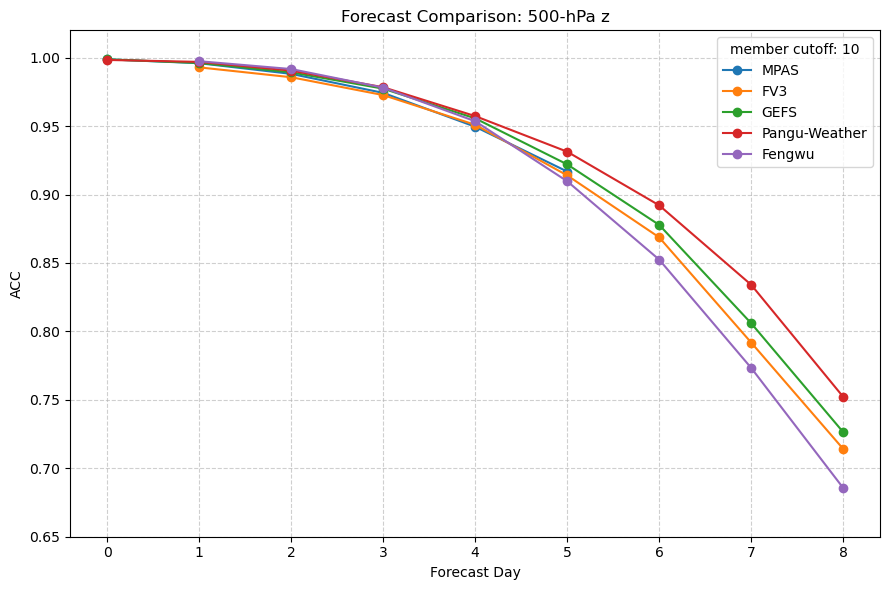

In [26]:
# Create a single figure and axes object
fig, ax = plt.subplots(figsize=(9, 6))

member_cutoff = 10

# Loop through each model to calculate and plot its ACC
for ds_model, title in zip(
    [ds_mpas, ds_fv3, ds_gefs, ds_pangu, ds_fengwu], ["MPAS", "FV3", "GEFS", "Pangu-Weather", "Fengwu"]
):


    ds_model = ds_model.sel(number=slice(None, member_cutoff))
    # Calculate the anomaly
    anom = ds_model.groupby("valid_time.dayofyear") - ds_climo
    
    # Calculate the Anomaly Correlation Coefficient (ACC)
    acc = xr.corr(
        anom[shortName].mean(dim="number"),
        anom_truth[shortName].sel(valid_time=anom.valid_time),
        dim=["latitude", "longitude", "initialization_time"],
    )
    
    # Convert forecast_hour to days for the x-axis
    acc = acc.assign_coords(day=acc.forecast_hour / 24)
    
    # Plot the ACC line on the single axes, using the model title as the label
    acc.plot.line(ax=ax, x="day", marker="o", label=title)

# --- Configure the final plot ---

# Set a single title for the chart
ax.set_title(f"Forecast Comparison: {isobaricInhPa}-hPa {shortName}")

# Set labels for the axes
ax.set_ylabel(f"ACC")
ax.set_xlabel("Forecast Day")

ax.set_ylim(bottom=0.65, top=1.02)

# Add a grid and a legend
ax.grid(True, linestyle="--", alpha=0.6)
ax.legend(title=f"member cutoff: {member_cutoff}")

# Adjust layout to prevent labels from overlapping
plt.tight_layout()

ofile=f"plots/acc.{shortName}{isobaricInhPa}.{member_cutoff}memcutoff.png"
fig.savefig(ofile)
print(ofile)

In [65]:
interp1d(range(len(a), fp, fill_value="extrapolate")

<class 'numpy.ndarray'>


In [42]:
import numpy as np
from skimage.transform import resize

a = np.array([[1, 2, 4], [0.,0,0]])

# Use order=1 for linear interpolation
result = resize(a, (a.shape[0]*2, a.shape[1]*2), order=1, mode='edge', anti_aliasing=False)
# The result will no longer have tiny artifact values.
print(np.round(result, 2))

[[1.   1.25 1.75 2.5  3.5  4.  ]
 [0.75 0.94 1.31 1.88 2.62 3.  ]
 [0.25 0.31 0.44 0.62 0.88 1.  ]
 [0.   0.   0.   0.   0.   0.  ]]


In [ ]:
ds_pangu[shortName].plot.hist()

ds_pangu[shortName].mean().compute()

ds_pangu[shortName].min(), ds_pangu[shortName].max()

z = ds_pangu["z"]
# --- Please run this exact block of code with your DataArray 'z' ---

# 1. Print the full representation of your object 'z'
# This will show its name, dimensions, coordinates, and attributes.
print("--- Full representation of the DataArray 'z' ---")
print(z)
print("-------------------------------------------------")


# 2. Calculate all three statistics back-to-back
min_val = z.min()
max_val = z.max()
mean_val = z.mean()

# 3. Print the results
print(f"Min value from .min(): {min_val.item()}")
print(f"Max value from .max(): {max_val.item()}")
print(f"Mean value from .mean(): {mean_val.item()}")


# 4. Perform the crucial consistency check
is_consistent = min_val <= mean_val <= max_val

print("\n--- Consistency Check ---")
print(f"Is the result mathematically consistent? {is_consistent}")
print("-------------------------")

# This forces a true NumPy calculation on the in-memory data,
# bypassing any xarray/cfgrib backend magic.
true_mean = z.values.mean()

print(f"The TRUE mathematical mean is: {true_mean}")

z.attrs

# del(z.attrs['GRIB_paramId'])
# del(z.attrs['GRIB_cfName'])
# del(z.attrs['GRIB_cfVarName'])
# del(z.attrs['GRIB_name'])
# del(z.attrs['GRIB_shortName'])
z.attrs.update({"long_name": "Geopotential Height", "standard_name": "geopotential height"})
z.mean()

ds_fengwu[shortName].plot.hist()

ds_gefs[shortName].plot.hist()

In [49]:
# reran fengwu to get values. they were all zero at first.
initialization_time = pd.Timestamp("20240526")
mem="p29"
ifiles = Path(f"/glade/derecho/scratch/ahijevyc/ai-models/output/fengwu/{initialization_time:%Y%m%d%H}/{mem}").glob("f*.nc")
junk = xr.open_mfdataset(ifiles, decode_timedelta=True)
if shortName == "z":
    junk = junk / g.m

prediction_timedelta = pd.to_timedelta(np.arange(1,11), unit='D')

fixed_values = junk.__xarray_dataarray_variable__.sel(channel=f'{shortName}{isobaricInhPa}', prediction_timedelta=prediction_timedelta).load()

target_labels = dict(number=int(mem[1:]), initialization_time=initialization_time)

ds_fengwu[shortName].loc[target_labels] = fixed_values.squeeze().values

In [50]:
ofile = CACHEDIR / f"fengwu.{isobaricInhPa}{shortName}.{years}.{forecast_length:03d}h.zarr2"

ds_fengwu.to_zarr(ofile)

/glade/work/ahijevyc/conda-envs/daa/lib/python3.12/site-packages/zarr/core/dtype/npy/string.py:248: UnstableSpecificationWarning: The data type (FixedLengthUTF32(length=4, endianness='little')) does not have a Zarr V3 specification. That means that the representation of arrays saved with this data type may change without warning in a future version of Zarr Python. Arrays stored with this data type may be unreadable by other Zarr libraries. Use this data type at your own risk! Check https://github.com/zarr-developers/zarr-extensions/tree/main/data-types for the status of data type specifications for Zarr V3.
  v3_unstable_dtype_warning(self)
/glade/work/ahijevyc/conda-envs/daa/lib/python3.12/site-packages/zarr/api/asynchronous.py:229: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


In [10]:
# they were all zero at first.
ifile = Path("/glade/derecho/scratch/ahijevyc/tmp/fengwu_gefs_pred_048.nc")
junk = xr.open_mfdataset(ifile)
junk.__xarray_dataarray_variable__.sel(channel='t850').load()

<xarray.DataArray '__xarray_dataarray_variable__' (init_time: 1,
                                                   prediction_timedelta: 1,
                                                   lat: 161, lon: 321)> Size: 413kB
array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]])
Coordinates:
  * init_time             (init_time) datetime64[ns] 8B 2024-05-29
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 8B 2 days
    channel               <U4 16B 't850'
  * lat                   (lat) float64 1kB 60.0 59.75 59.5 ... 20.5 20.25 20.0
  * lon                   (lon) float64 3kB 220.0 220.2 220.5 ... 299.8 300.0

In [ ]:
# instead of recreating the zarr, just load the existing one and drop the extra init times and resave it with .zarr2 extension
# Then rename the old one with _hide suffix and rename the .zarr2 extension .zarr.
times_to_drop = pd.date_range('2023-06-01', '2023-06-07').union(pd.date_range('2024-06-01','2024-06-07'))
ds_gefs = ds_gefs.drop_sel(initialization_time=times_to_drop)
ds_gefs

ds_gefs.to_zarr(ofile.with_suffix(".zarr2"))